In [1]:
from google.colab import files
files.upload()

Saving model.py to model (1).py


{'model (1).py': b'\nimport torch.nn as nn\nimport torch.nn.functional as F\n\nclass Net(nn.Module):\n      def __init__(self):\n          super(Net, self).__init__()\n\n          # Prep Layer\n          self.prepblock = nn.Sequential(\n              nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride=1,padding = 1),\n              nn.BatchNorm2d(64),\n              nn.ReLU(),\n              #nn.Dropout(0.2)\n\n          ) # output_size = 32\n\n\n          #Residual blk1 R1\n          self.R1 = nn.Sequential(\n              nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1,padding = 1),\n              nn.BatchNorm2d(128),\n              nn.ReLU(),\n              nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=2,padding = 1),\n              nn.BatchNorm2d(128),\n              nn.ReLU(),\n\n          ) # output\n\n\n          # Layer 1\n          self.convblockx1 = nn.Sequential(\n              nn.Conv2d(in_channels=64, out_

In [2]:
pip install torch_lr_finder

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from model import Net
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from torch_lr_finder import LRFinder

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
class Cifar10SearchDataset(datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)


train_transform = A.Compose(
    [
        A.RandomCrop(32,32,always_apply=True),
        A.HorizontalFlip(p=0.5),
        A.Cutout(num_holes=1, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
        A.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
   [
        A.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ToTensorV2(),
    ]
)

'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
'''
trainset = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, num_workers=2)

testset = Cifar10SearchDataset(root='./data', train=False,
                                       download=True,transform = test_transform)
test_loader =torch.utils.data.DataLoader(testset, batch_size=512,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


 ship  bird   cat   dog


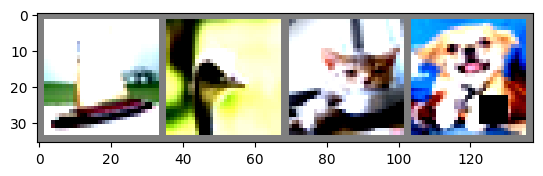

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]         147,584
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 32, 32]          73,856
        MaxPool2d-11          [-1, 128, 16, 16]               0
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
          Dropout-14          [-1,

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
from torch.optim.lr_scheduler import OneCycleLR

model =  Net().to(device)
EPOCHS = 24
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-2)
scheduler = OneCycleLR(optimizer, max_lr=1.91E-03,
                      pct_start = 5/EPOCHS,
                      steps_per_epoch=len(train_loader),
                      div_factor = 100,
                      final_div_factor = 100,
                      three_phase = False,
                      epochs=EPOCHS)


for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.5823380947113037 Batch_id=97 Accuracy=35.31: 100%|██████████| 98/98 [01:05<00:00,  1.49it/s]



Test set: Average loss: 1.4691, Accuracy: 4803/10000 (48.03%)

EPOCH: 1


Loss=1.217275857925415 Batch_id=97 Accuracy=51.16: 100%|██████████| 98/98 [01:06<00:00,  1.48it/s]



Test set: Average loss: 1.2792, Accuracy: 5544/10000 (55.44%)

EPOCH: 2


Loss=1.2006456851959229 Batch_id=97 Accuracy=56.79: 100%|██████████| 98/98 [01:06<00:00,  1.47it/s]



Test set: Average loss: 1.1627, Accuracy: 5918/10000 (59.18%)

EPOCH: 3


Loss=1.146722674369812 Batch_id=97 Accuracy=61.25: 100%|██████████| 98/98 [01:06<00:00,  1.47it/s]



Test set: Average loss: 1.0821, Accuracy: 6219/10000 (62.19%)

EPOCH: 4


Loss=1.049534797668457 Batch_id=97 Accuracy=64.53: 100%|██████████| 98/98 [01:06<00:00,  1.48it/s]



Test set: Average loss: 1.0171, Accuracy: 6461/10000 (64.61%)

EPOCH: 5


Loss=0.9073737263679504 Batch_id=97 Accuracy=67.31: 100%|██████████| 98/98 [01:07<00:00,  1.46it/s]



Test set: Average loss: 0.9661, Accuracy: 6594/10000 (65.94%)

EPOCH: 6


Loss=0.8554415106773376 Batch_id=97 Accuracy=69.50: 100%|██████████| 98/98 [01:06<00:00,  1.47it/s]



Test set: Average loss: 0.9200, Accuracy: 6813/10000 (68.13%)

EPOCH: 7


Loss=0.8331700563430786 Batch_id=97 Accuracy=71.61: 100%|██████████| 98/98 [01:06<00:00,  1.47it/s]



Test set: Average loss: 0.8779, Accuracy: 6924/10000 (69.24%)

EPOCH: 8


Loss=0.7890298962593079 Batch_id=97 Accuracy=73.36: 100%|██████████| 98/98 [01:06<00:00,  1.47it/s]



Test set: Average loss: 0.8458, Accuracy: 7033/10000 (70.33%)

EPOCH: 9


Loss=0.7125495076179504 Batch_id=97 Accuracy=74.90: 100%|██████████| 98/98 [01:06<00:00,  1.46it/s]



Test set: Average loss: 0.8205, Accuracy: 7157/10000 (71.57%)

EPOCH: 10


Loss=0.7582247257232666 Batch_id=97 Accuracy=76.32: 100%|██████████| 98/98 [01:06<00:00,  1.47it/s]



Test set: Average loss: 0.7986, Accuracy: 7198/10000 (71.98%)

EPOCH: 11


Loss=0.7242411375045776 Batch_id=97 Accuracy=77.79: 100%|██████████| 98/98 [01:06<00:00,  1.47it/s]



Test set: Average loss: 0.7798, Accuracy: 7311/10000 (73.11%)

EPOCH: 12


Loss=0.6376214623451233 Batch_id=97 Accuracy=78.86: 100%|██████████| 98/98 [01:06<00:00,  1.48it/s]



Test set: Average loss: 0.7570, Accuracy: 7427/10000 (74.27%)

EPOCH: 13


Loss=0.6720086336135864 Batch_id=97 Accuracy=80.01: 100%|██████████| 98/98 [01:06<00:00,  1.47it/s]



Test set: Average loss: 0.7508, Accuracy: 7421/10000 (74.21%)

EPOCH: 14


Loss=0.5817723870277405 Batch_id=97 Accuracy=81.18: 100%|██████████| 98/98 [01:06<00:00,  1.47it/s]



Test set: Average loss: 0.7273, Accuracy: 7483/10000 (74.83%)

EPOCH: 15


Loss=0.5584065318107605 Batch_id=97 Accuracy=82.11: 100%|██████████| 98/98 [01:06<00:00,  1.47it/s]



Test set: Average loss: 0.7123, Accuracy: 7575/10000 (75.75%)

EPOCH: 16


Loss=0.5508773326873779 Batch_id=97 Accuracy=83.03: 100%|██████████| 98/98 [01:06<00:00,  1.47it/s]



Test set: Average loss: 0.7008, Accuracy: 7610/10000 (76.10%)

EPOCH: 17


Loss=0.5506733059883118 Batch_id=97 Accuracy=83.95: 100%|██████████| 98/98 [01:06<00:00,  1.47it/s]



Test set: Average loss: 0.6840, Accuracy: 7678/10000 (76.78%)

EPOCH: 18


Loss=0.49423399567604065 Batch_id=97 Accuracy=84.91: 100%|██████████| 98/98 [01:07<00:00,  1.46it/s]



Test set: Average loss: 0.6895, Accuracy: 7658/10000 (76.58%)

EPOCH: 19


Loss=0.5218896865844727 Batch_id=97 Accuracy=85.81: 100%|██████████| 98/98 [01:07<00:00,  1.46it/s]



Test set: Average loss: 0.6597, Accuracy: 7779/10000 (77.79%)

EPOCH: 20


Loss=0.4726031720638275 Batch_id=97 Accuracy=86.59: 100%|██████████| 98/98 [01:06<00:00,  1.47it/s]



Test set: Average loss: 0.6546, Accuracy: 7757/10000 (77.57%)

EPOCH: 21


Loss=0.43003177642822266 Batch_id=97 Accuracy=87.42: 100%|██████████| 98/98 [01:06<00:00,  1.46it/s]



Test set: Average loss: 0.6490, Accuracy: 7777/10000 (77.77%)

EPOCH: 22


Loss=0.3970627188682556 Batch_id=97 Accuracy=88.29: 100%|██████████| 98/98 [01:06<00:00,  1.47it/s]



Test set: Average loss: 0.6385, Accuracy: 7809/10000 (78.09%)

EPOCH: 23


Loss=0.43420591950416565 Batch_id=97 Accuracy=88.99: 100%|██████████| 98/98 [01:06<00:00,  1.47it/s]



Test set: Average loss: 0.6356, Accuracy: 7857/10000 (78.57%)



In [10]:
'''
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
'''

'\ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)\nlr_finder = LRFinder(model, optimizer, criterion, device="cuda")\nlr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")\n'

In [11]:
#lr_finder.plot()

In [12]:
#lr_finder.reset()